### **The GitHub Branching process**

**Open your terminal**
file -> new terminal 

**Ensure you are on main and up to date**
git checkout main
git pull origin main

**Create and switch to new branch**
git checkout -b your-name/feature-description

**Add your changes (specific)**
git add notebooks/task_1.ipynb

**Or add all changes**
git add .

**Commit with clear message**
git commit -m "Complete data cleaning for task 1"
git push origin dhruv/task1-analysis

**Go to GitHub and open a Pull Request**



**1.1. Roadmap** 
1. getting our data
2. look at basic info - shape, info, missingness
3. Figure out target variable categories 
4. sample - stratify to mainatain balance between classes
5. save sampled data to new csv 
6. EDA and visualisations 
7. encode the target variable (there are 8 variable types, maybe label encode)



In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px 
import plotly.graph_objects as go

import missingno as msno 

from sklearn.preprocessing import LabelEncoder

In [5]:
df = pd.read_csv("../data/raw/data-1.csv")
df.head()

,land_type,p_x,p_y,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,...,Band_211,Band_212,Band_213,Band_214,Band_215,Band_216,Band_217,Band_218,rgb_hex,overlay_hex
0,valley floor / meadow,0,0,0.0174,0.0131,0.0108,0.0133,0.0158,0.0144,0.0151,...,0.0237,0.0231,0.0224,0.0246,0.0255,0.0174,0.0234,0.0147,#030B05,#25C77140
1,valley floor / meadow,1,0,0.0180,0.0124,0.0116,0.0143,0.0154,0.0136,0.0151,...,0.0289,0.0275,0.0288,0.0293,0.0286,0.0211,0.0229,0.0176,#040A09,#25C77140
2,valley floor / meadow,2,0,0.0151,0.0150,0.0113,0.0158,0.0167,0.0158,0.0163,...,0.0358,0.0319,0.0355,0.0274,0.0303,0.0232,0.0282,0.0181,#08110B,#25C77140
3,valley floor / meadow,3,0,0.0172,0.0149,0.0095,0.0156,0.0154,0.0169,0.0176,...,0.0310,0.0294,0.0307,0.0238,0.0304,0.0232,0.0247,0.0087,#0C160C,#25C77140
4,valley floor / meadow,4,0,0.0184,0.0149,0.0143,0.0189,0.0174,0.0174,0.0182,...,0.0428,0.0372,0.0407,0.0344,0.0415,0.0287,0.0317,0.0176,#0E180C,#25C77140


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215604 entries, 0 to 215603
Columns: 223 entries, land_type to overlay_hex
dtypes: float64(218), int64(2), object(3)
memory usage: 366.8+ MB


In [7]:
df.describe()

,p_x,p_y,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,...,Band_209,Band_210,Band_211,Band_212,Band_213,Band_214,Band_215,Band_216,Band_217,Band_218
count,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,...,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000
mean,176.934871,303.167789,0.095601,0.094335,0.095621,0.099081,0.100492,0.101252,0.102764,0.104476,...,0.110929,0.108438,0.108563,0.105381,0.105773,0.100424,0.099806,0.095834,0.092850,0.086839
std,102.491875,175.323061,0.164291,0.163833,0.165067,0.166807,0.167414,0.167216,0.167939,0.168141,...,0.059208,0.059431,0.059182,0.059277,0.058764,0.057765,0.056946,0.057251,0.054999,0.056024
min,0.000000,0.000000,-0.012000,-0.012600,-0.011900,-0.008800,-0.009300,-0.009000,-0.007700,-0.007500,...,0.007400,0.005700,0.006900,0.003600,0.006800,0.002400,0.004100,0.001100,0.000100,-0.010000
25%,88.000000,151.000000,0.022600,0.020600,0.020000,0.022900,0.023400,0.023800,0.024500,0.025500,...,0.058600,0.055700,0.056000,0.052500,0.053500,0.048900,0.048900,0.044400,0.043600,0.036300
50%,177.000000,303.000000,0.037800,0.036800,0.037700,0.040600,0.041600,0.042200,0.043400,0.045300,...,0.101100,0.098200,0.098200,0.094900,0.095000,0.089600,0.089000,0.085100,0.082300,0.076000
75%,266.000000,455.000000,0.078000,0.078000,0.081100,0.083800,0.086100,0.087700,0.090000,0.092700,...,0.157700,0.155500,0.155300,0.152500,0.152300,0.146400,0.145100,0.141500,0.136700,0.132000
max,354.000000,607.000000,1.581000,1.574100,1.587100,1.595900,1.603600,1.605300,1.609500,1.613800,...,0.453700,0.446600,0.453600,0.449000,0.446700,0.429900,0.435100,0.433000,0.429100,0.411200


In [8]:
# lets take a look at unique values for land_type
df["land_type"].unique()
df["land_type"].value_counts()

land_type
alpine meadow            50657
alpine tundra            38900
valley floor / meadow    38424
bare rock                26314
veg-scree mix            24495
scree / sunlit rock      15153
snow / ice               11533
dark rock                10128
Name: count, dtype: int64

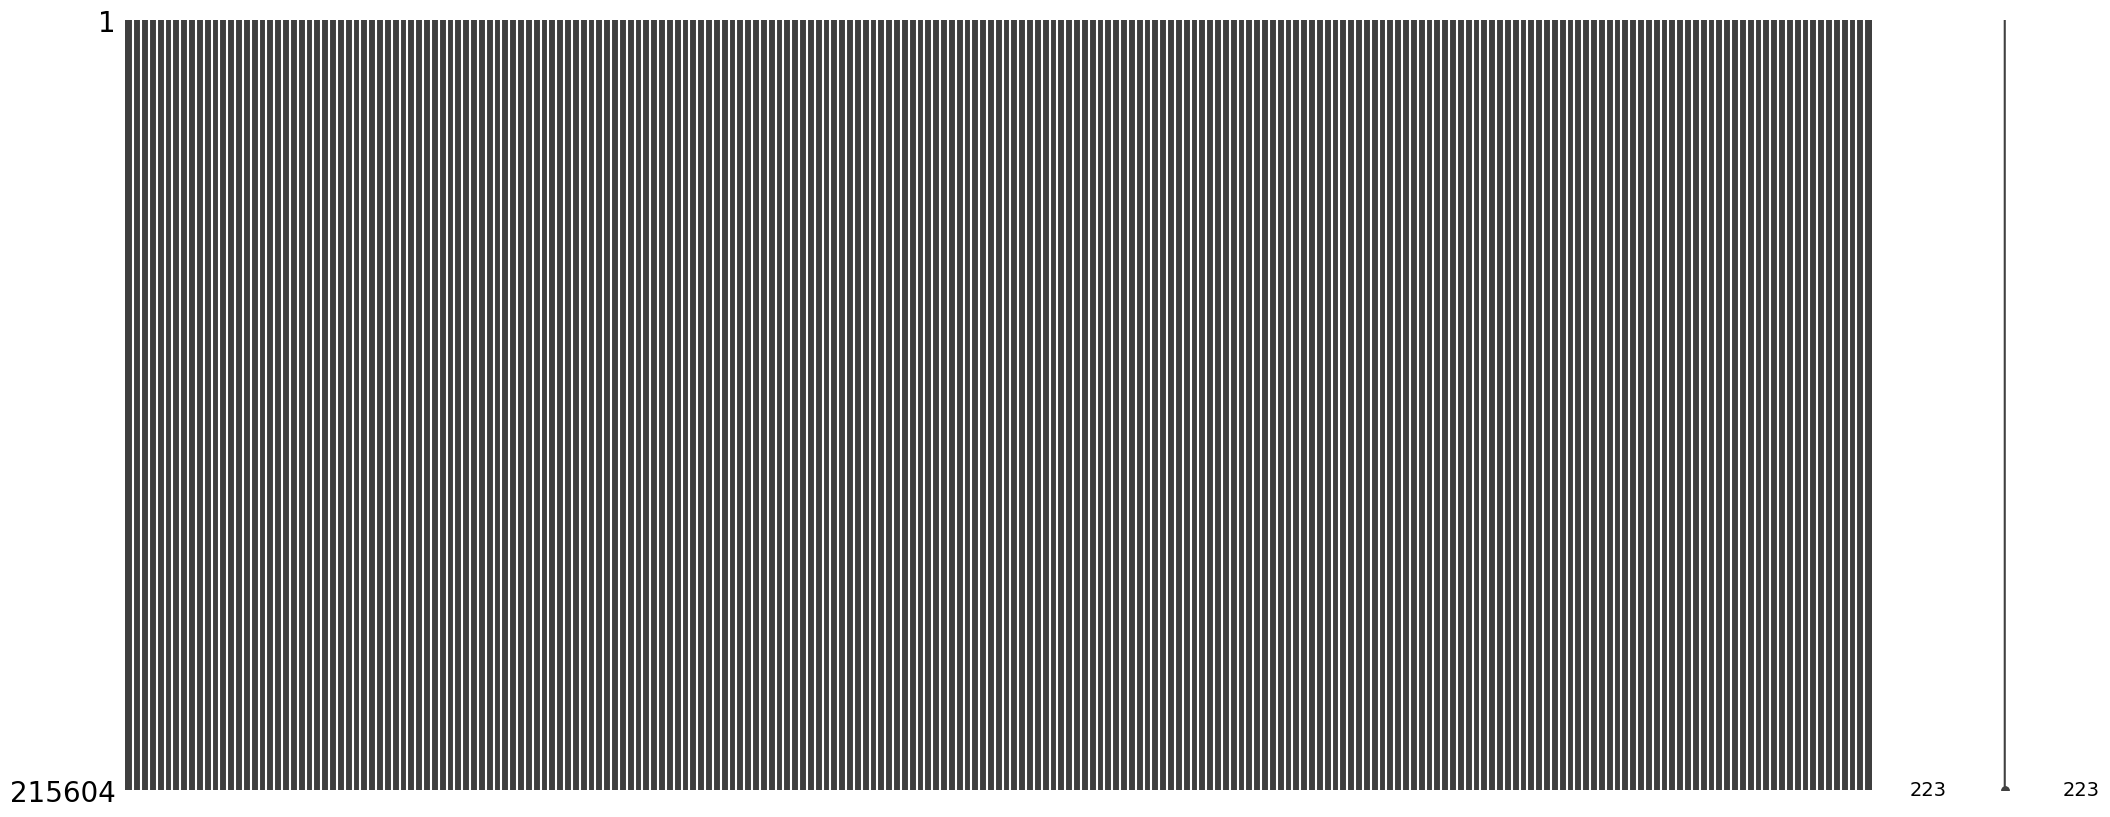

In [9]:
# lets visualise missing data 
msno.matrix(df)
plt.show()

In [10]:
# Stratified sampling the RIGHT way:
sample_size = 50000
sample_fraction = sample_size / len(df)

df_sample = df.groupby('land_type', group_keys=False).apply(
    lambda x: x.sample(frac=sample_fraction, random_state=42)
)

C:\Users\dhruv\AppData\Local\Temp\ipykernel_18668\491869911.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df.groupby('land_type', group_keys=False).apply(


In [11]:
df_sample.head()

,land_type,p_x,p_y,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,...,Band_211,Band_212,Band_213,Band_214,Band_215,Band_216,Band_217,Band_218,rgb_hex,overlay_hex
15920,alpine meadow,300,44,0.0238,0.0214,0.0202,0.0223,0.0228,0.0231,0.0257,...,0.0616,0.0567,0.0573,0.0523,0.0508,0.0488,0.0473,0.0428,#1B1A13,#4B005540
91192,alpine meadow,312,256,0.0359,0.0361,0.0365,0.0399,0.0384,0.0388,0.0399,...,0.0930,0.0889,0.0897,0.0812,0.0814,0.0801,0.0748,0.0659,#2B2F21,#4B005540
108272,alpine meadow,352,304,0.0266,0.0248,0.0241,0.0257,0.0286,0.0278,0.0270,...,0.0709,0.0648,0.0663,0.0619,0.0586,0.0544,0.0528,0.0522,#1C1F15,#4B005540
189652,alpine meadow,82,534,0.0200,0.0181,0.0171,0.0198,0.0196,0.0202,0.0204,...,0.0465,0.0439,0.0427,0.0418,0.0400,0.0344,0.0368,0.0324,#0F0E0E,#4B005540
202127,alpine meadow,132,569,0.0410,0.0375,0.0364,0.0406,0.0419,0.0405,0.0427,...,0.0982,0.0917,0.0983,0.0924,0.0843,0.0749,0.0816,0.0724,#292E22,#4B005540


In [12]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50001 entries, 15920 to 197545
Columns: 223 entries, land_type to overlay_hex
dtypes: float64(218), int64(2), object(3)
memory usage: 85.5+ MB


In [13]:
# Save sample to data/raw folder
df_sample.to_csv('../data/raw/data_sample.csv', index=False)

In [14]:
df_sample_land_type = df_sample['land_type'].value_counts()
df_sample_land_type

land_type
alpine meadow            11748
alpine tundra             9021
valley floor / meadow     8911
bare rock                 6102
veg-scree mix             5681
scree / sunlit rock       3514
snow / ice                2675
dark rock                 2349
Name: count, dtype: int64

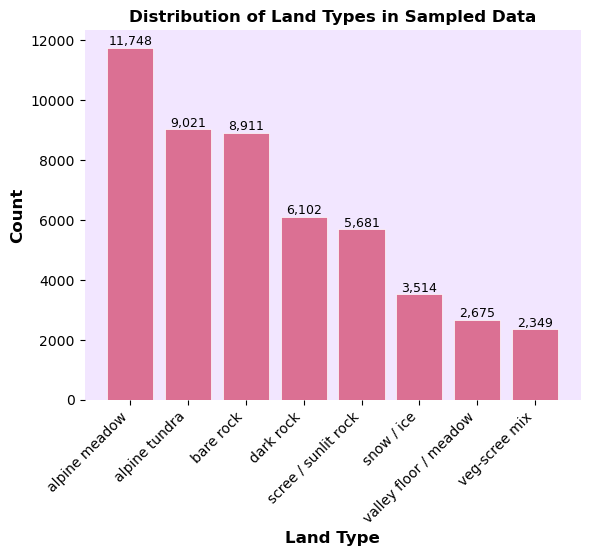

<Figure size 1000x800 with 0 Axes>

In [15]:
bars = plt.bar(df_sample['land_type'].unique(), df_sample_land_type, color='palevioletred', edgecolor='white', linewidth=0.5) 

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{int(height):,}',
             ha='center', va='bottom', fontsize=9)
    
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(False)
plt.gca().spines['bottom'].set_linewidth(False)
plt.gca().set_facecolor('#f2e6ff')
plt.title('Distribution of Land Types in Sampled Data', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Land Type', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=12, fontweight='bold')


plt.figure(figsize=(10,8))
plt.show()

In [16]:
perc_real = (df['land_type'].value_counts() / len(df)) * 100
perc_sample = (df_sample['land_type'].value_counts() / len(df_sample)) * 100

pd.DataFrame({
    'Real Data Percentage': perc_real,
    'Sampled Data Percentage': perc_sample
})

,Real Data Percentage,Sampled Data Percentage
land_type,,
alpine meadow,23.495390,23.495530
alpine tundra,18.042337,18.041639
valley floor / meadow,17.821562,17.821644
bare rock,12.204783,12.203756
veg-scree mix,11.361106,11.361773
scree / sunlit rock,7.028163,7.027859
snow / ice,5.349159,5.349893
dark rock,4.697501,4.697906


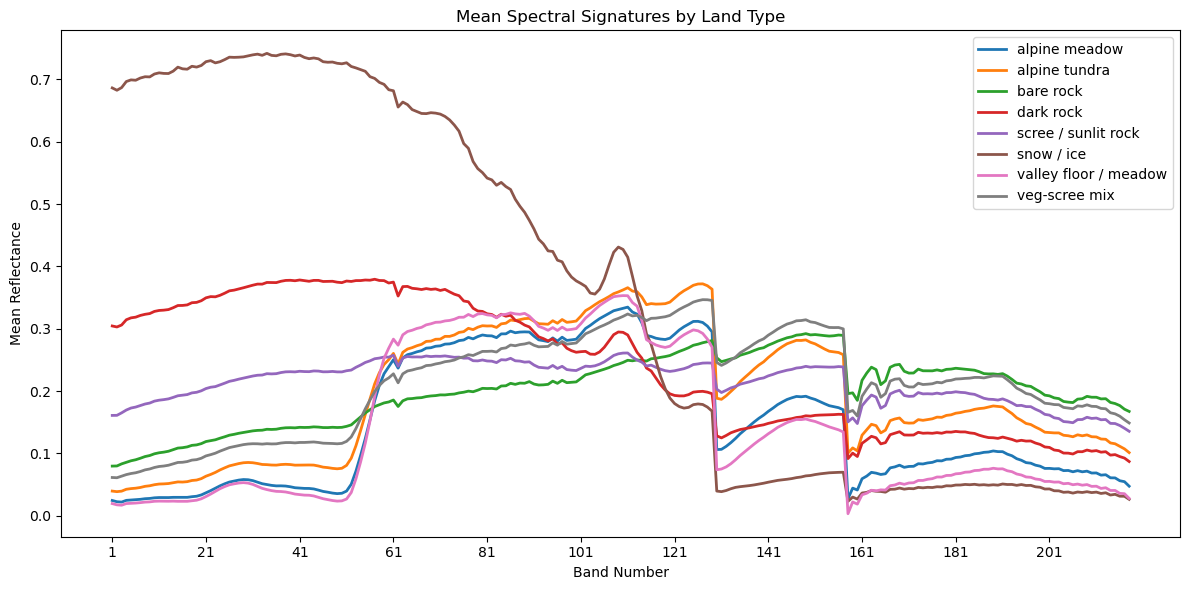

In [17]:
# Get the band columns
band_columns = [f'Band_{i}' for i in range(1, 219)]

# Create the plot
plt.figure(figsize=(12, 6))

# For each land type, calculate and plot the mean reflectance
for land_type in df_sample['land_type'].unique():
    # Get rows for this land type
    land_data = df_sample[df_sample['land_type'] == land_type]
    
    # Calculate mean reflectance for each band
    mean_reflectance = land_data[band_columns].mean()
    
    # Plot it
    plt.plot(mean_reflectance, label=land_type, linewidth=2)

# Add labels and legend
plt.xticks(ticks=np.arange(0, 219, 20), labels=np.arange(1, 218, 20))
plt.xlabel('Band Number')
plt.ylabel('Mean Reflectance')
plt.title('Mean Spectral Signatures by Land Type')
plt.legend()
plt.tight_layout()
plt.show()

This line plot shows us the mean reflectance of each land type. (eg. ice is way more reflective)

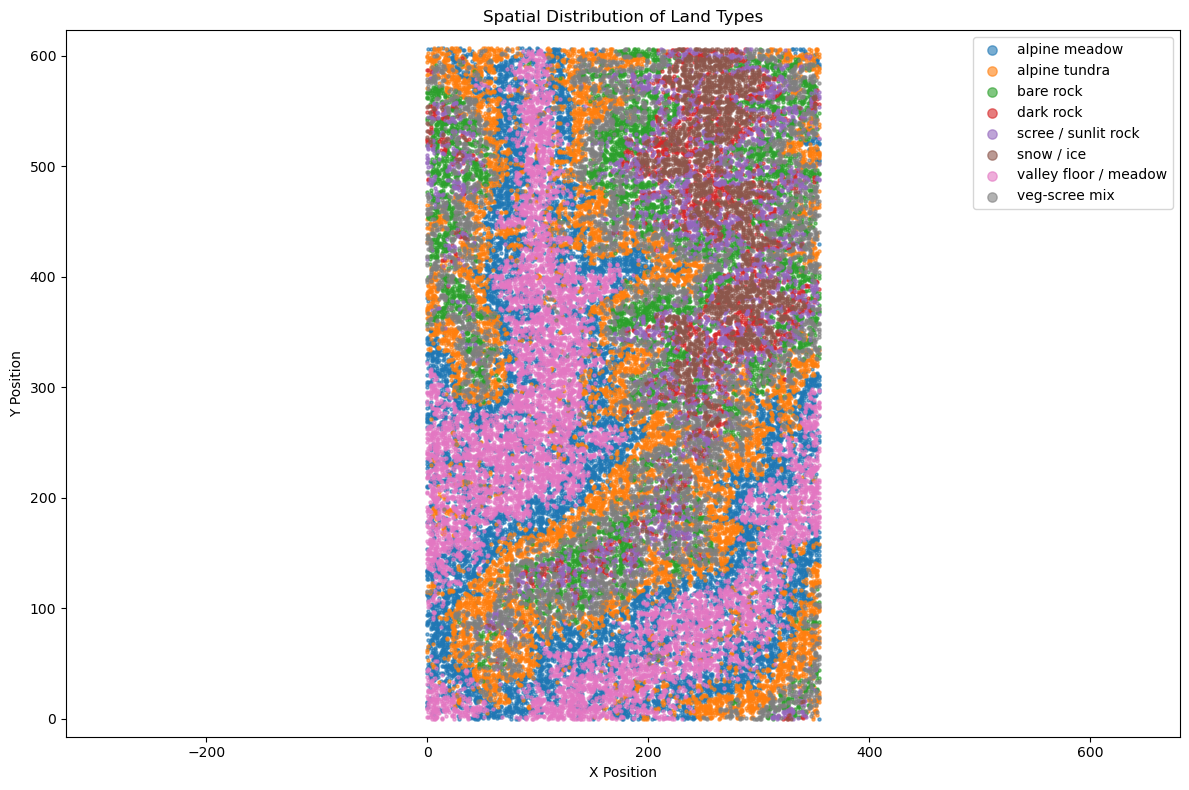

In [18]:
plt.figure(figsize=(12, 8))

# Plot each land type with different color
for land_type in df_sample['land_type'].unique():
    land_data = df_sample[df_sample['land_type'] == land_type]
    plt.scatter(land_data['p_x'], land_data['p_y'], 
                label=land_type, alpha=0.6, s=5)

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Spatial Distribution of Land Types')
plt.legend(markerscale=3)
plt.axis('equal')  # Makes x and y scales the same
plt.tight_layout()
plt.show()

### **Encoding Target**

- Convert categorical land_type labels into numerical values (0-7)

- LabelEncoder assigns a unique integer to each vegetation class

- Save mapping so we can interpret results later
- Keep original 'land_type' column for reference during EDA

In [20]:
# Create label encoder
le = LabelEncoder()

# Encode land_type to numerical values
df_sample['land_type_encoded'] = le.fit_transform(df_sample['land_type'])

# Check mapping
print("Class mapping:")
for i, class_name in enumerate(le.classes_):
    print(f"{i}: {class_name}")
    
print(f"\nOriginal: {df_sample['land_type'].head()}")
print(f"Encoded: {df_sample['land_type_encoded'].head()}")

Class mapping:
0: alpine meadow
1: alpine tundra
2: bare rock
3: dark rock
4: scree / sunlit rock
5: snow / ice
6: valley floor / meadow
7: veg-scree mix

Original: 15920     alpine meadow
91192     alpine meadow
108272    alpine meadow
189652    alpine meadow
202127    alpine meadow
Name: land_type, dtype: object
Encoded: 15920     0
91192     0
108272    0
189652    0
202127    0
Name: land_type_encoded, dtype: int32


In [21]:
# Select only the spectral bands as features
band_columns = [f'Band_{i}' for i in range(1, 219)]  # Band_1 to Band_218
X = df_sample[band_columns]

# Set target variable
y = df_sample['land_type_encoded']

# Check dimensions
print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nFirst few features:\n{X.head()}")

Feature matrix shape: (50001, 218)
Target vector shape: (50001,)

First few features:
        Band_1  Band_2  Band_3  Band_4  Band_5  Band_6  Band_7  Band_8  \
15920   0.0238  0.0214  0.0202  0.0223  0.0228  0.0231  0.0257  0.0248   
91192   0.0359  0.0361  0.0365  0.0399  0.0384  0.0388  0.0399  0.0421   
108272  0.0266  0.0248  0.0241  0.0257  0.0286  0.0278  0.0270  0.0285   
189652  0.0200  0.0181  0.0171  0.0198  0.0196  0.0202  0.0204  0.0215   
202127  0.0410  0.0375  0.0364  0.0406  0.0419  0.0405  0.0427  0.0435   

        Band_9  Band_10  ...  Band_209  Band_210  Band_211  Band_212  \
15920   0.0255   0.0261  ...    0.0610    0.0577    0.0616    0.0567   
91192   0.0419   0.0428  ...    0.0952    0.0957    0.0930    0.0889   
108272  0.0277   0.0294  ...    0.0728    0.0707    0.0709    0.0648   
189652  0.0207   0.0226  ...    0.0474    0.0439    0.0465    0.0439   
202127  0.0441   0.0465  ...    0.1103    0.0993    0.0982    0.0917   

        Band_213  Band_214  Band_215

### **Train-Test Split**

- We split our data into 80% training and 20% test sets to evaluate model performance

- We use stratified splitting to maintain the same class proportions in both train and test sets

- We set random_state=42 for reproducibility so our results are consistent

- We verify the split worked correctly and classes are balanced across both sets

In [22]:
from sklearn.model_selection import train_test_split

# Split data into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,  # Maintain class distribution
    random_state=42
)

# Check split sizes
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nClass distribution in train set:")
print(y_train.value_counts().sort_index())

Training set: (40000, 218)
Test set: (10001, 218)

Class distribution in train set:
land_type_encoded
0    9398
1    7217
2    4881
3    1879
4    2811
5    2140
6    7129
7    4545
Name: count, dtype: int64


- We standardize all 218 spectral bands to have mean=0 and std=1

- We fit the scaler only on training data to prevent data leakage from test set

- We apply the same transformation to test data using the training set's parameters

- Scaling is crucial for PCA since it's sensitive to feature magnitudes

In [23]:
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Fit on training data and transform both sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Verify scaling worked
print(f"Original training data - Mean: {X_train.mean().mean():.3f}, Std: {X_train.std().mean():.3f}")
print(f"Scaled training data - Mean: {X_train_scaled.mean():.3f}, Std: {X_train_scaled.std():.3f}")

Original training data - Mean: 0.190, Std: 0.104
Scaled training data - Mean: 0.000, Std: 1.000


### **Principal Component Analysis**

- We apply PCA to reduce 218 spectral bands down to 10 principal components

- We fit PCA on training data only to avoid data leakage

- We transform test data using the same PCA transformation learned from training

- We check how much variance is captured by these 10 components to understand information loss

In [24]:
from sklearn.decomposition import PCA

# Initialize PCA with 10 components
pca = PCA(n_components=10, random_state=42)

# Fit and transform training data
X_train_pca = pca.fit_transform(X_train_scaled)

# Transform test data (using training PCA fit)
X_test_pca = pca.transform(X_test_scaled)

# Check results
print(f"Original dimensions: {X_train_scaled.shape}")
print(f"PCA dimensions: {X_train_pca.shape}")
print(f"\nExplained variance by each component:")
print(pca.explained_variance_ratio_)
print(f"\nTotal variance explained: {pca.explained_variance_ratio_.sum():.3f}")

Original dimensions: (40000, 218)
PCA dimensions: (40000, 10)

Explained variance by each component:
[4.59886780e-01 3.43921087e-01 1.89866529e-01 3.41856658e-03
 8.22334916e-04 4.72967541e-04 3.40696111e-04 2.76719059e-04
 1.85350616e-04 1.36871160e-04]

Total variance explained: 0.999


- We show how much variance each of the 10 components captures individually

- We display cumulative variance to see that just 3 components explain 99% of variation

- We confirm our choice of 10 components is more than sufficient for the classification task

- These plots help justify dimensionality reduction to reviewers

**Why first 3 PCs might be explaining so much:**

- Adjacent wavelength bands are highly correlated (Band_50 ≈ Band_51)
- 218 bands capture redundant spectral information
- Vegetation has strong, consistent spectral signatures

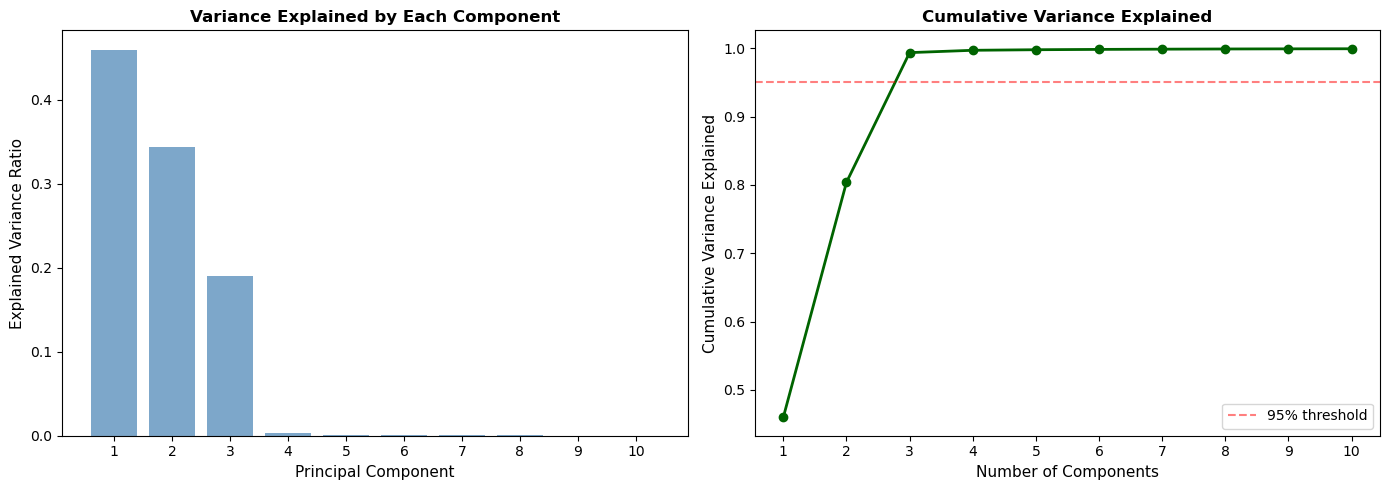

In [25]:

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Explained variance per component
axes[0].bar(range(1, 11), pca.explained_variance_ratio_, alpha=0.7, color='steelblue')
axes[0].set_xlabel('Principal Component', fontsize=11)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=11)
axes[0].set_title('Variance Explained by Each Component', fontsize=12, fontweight='bold')
axes[0].set_xticks(range(1, 11))

# Plot 2: Cumulative variance
cumsum = np.cumsum(pca.explained_variance_ratio_)
axes[1].plot(range(1, 11), cumsum, marker='o', linestyle='-', color='darkgreen', linewidth=2)
axes[1].axhline(y=0.95, color='red', linestyle='--', alpha=0.5, label='95% threshold')
axes[1].set_xlabel('Number of Components', fontsize=11)
axes[1].set_ylabel('Cumulative Variance Explained', fontsize=11)
axes[1].set_title('Cumulative Variance Explained', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].set_xticks(range(1, 11))

plt.tight_layout()
plt.show()

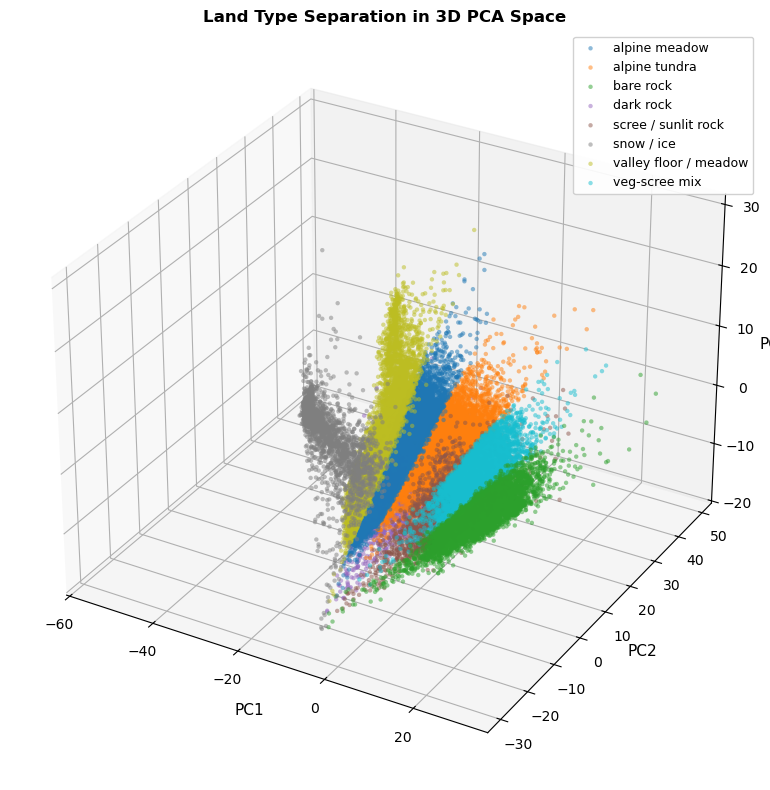

In [26]:

from mpl_toolkits.mplot3d import Axes3D

# Create 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Get unique classes
classes = np.unique(y_train)
colors = plt.cm.tab10(np.linspace(0, 1, len(classes)))

# Plot each class
for idx, class_label in enumerate(classes):
    mask = y_train == class_label
    ax.scatter(X_train_pca[mask, 0], X_train_pca[mask, 1], X_train_pca[mask, 2],
               c=[colors[idx]], label=le.classes_[class_label], 
               alpha=0.5, s=10, edgecolors='none')

ax.set_xlabel('PC1', fontsize=11)
ax.set_ylabel('PC2', fontsize=11)
ax.set_zlabel('PC3', fontsize=11)
ax.set_title('Land Type Separation in 3D PCA Space', fontsize=12, fontweight='bold')
ax.legend(loc='best', framealpha=0.9, fontsize=9)
plt.tight_layout()
plt.show()

### **Logistic Regression**



In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize baseline logistic regression
log_reg_baseline = LogisticRegression(random_state=42, max_iter=1000)

# Train on PCA training data
log_reg_baseline.fit(X_train_pca, y_train)

# Quick baseline performance check
y_pred_baseline = log_reg_baseline.predict(X_test_pca)
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)

print(f"Baseline Logistic Regression Accuracy: {baseline_accuracy:.4f}")

Baseline Logistic Regression Accuracy: 0.9901


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [28]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l2'],  # L2 regularization
    'solver': ['lbfgs', 'saga'],  # Different solvers
    'max_iter': [2000]  # Increased to fix convergence
}

# Initialize GridSearchCV with 5-fold cross-validation
log_reg_grid = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit on training data
print("Starting hyperparameter tuning...")
log_reg_grid.fit(X_train_pca, y_train)

# Best parameters
print(f"\nBest parameters: {log_reg_grid.best_params_}")
print(f"Best CV accuracy: {log_reg_grid.best_score_:.4f}")

Starting hyperparameter tuning...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best parameters: {'C': 10, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV accuracy: 0.9925


### **Support Vector Machine**



In [29]:
from sklearn.svm import SVC


# Define hyperparameter grid
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# GridSearchCV
svm_grid = GridSearchCV(
    SVC(random_state=42),
    param_grid_svm,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit
print("Starting SVM hyperparameter tuning...")
svm_grid.fit(X_train_pca, y_train)

print(f"\nBest parameters: {svm_grid.best_params_}")
print(f"Best CV accuracy: {svm_grid.best_score_:.4f}")

Starting SVM hyperparameter tuning...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV accuracy: 0.9928


### **Random Forest**

- We tune Random Forest's key hyperparameters controlling tree complexity and ensemble size

- We test different numbers of trees (n_estimators) and depth controls to prevent overfitting

- Random Forest can capture non-linear patterns through ensemble of decision trees

- Note: This may take 3-5 minutes due to more parameter combinations

In [30]:
from sklearn.ensemble import RandomForestClassifier


# Define hyperparameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# GridSearchCV
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit
print("Starting Random Forest hyperparameter tuning...")
rf_grid.fit(X_train_pca, y_train)

print(f"\nBest parameters: {rf_grid.best_params_}")
print(f"Best CV accuracy: {rf_grid.best_score_:.4f}")

Starting Random Forest hyperparameter tuning...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best CV accuracy: 0.9691


### **Gradient Boosting for Decision Trees**

- We tune GBDT's learning rate, tree depth, and ensemble size for sequential boosting

- As we know, GBDT builds trees sequentially, correcting errors from previous trees

- Subsample parameter controls bagging to reduce overfitting

- Note: This may take 5-10 minutes as boosting is more computationally intensive

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier


# Define hyperparameter grid
param_grid_gbdt = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

# GridSearchCV
gbdt_grid = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid_gbdt,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit
print("Starting GBDT hyperparameter tuning...")
gbdt_grid.fit(X_train_pca, y_train)

print(f"\nBest parameters: {gbdt_grid.best_params_}")
print(f"Best CV accuracy: {gbdt_grid.best_score_:.4f}")